# Style Transfer notebook
## CS152 October 10, 2018  Neil Rhodes

We look at Neural Style Transfer (transferring the style of one image to the content of another) as defined in [*Image Style Transfer Using Convolutional Neural Networks* by Gatys, Ecker, and Bethge, 2016](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

Code based on [fastai style transfer notebook](https://github.com/fastai/fastai/blob/master/courses/dl2/style-transfer.ipynb).

In [ ]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We are interested in doing style transfer. We want to take a given image and recast it in the style of some other image.


In [154]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *

from fastai.sgdr import *
from fastai.plots import *

from pathlib import Path

## Utility Functions

In [155]:
def denorm(tensor, denormalizer):
    """Does the opposite of the transformation from tfms_from_model"""
    
    # Even though the transformer returned from tfms_from_model moves the channels
    # (from width, height, depth) to (1, channels, width, height), the denormalizer
    # returned from tfms_from_model doesn't convert back
    wid_height_depth = np.moveaxis(to_np(tensor),1,-1)[0]
    return denormalizer(wid_height_depth)

In [156]:
def draw_with_size(image, size_in_inches):
    plt.figure(figsize=(size_in_inches, size_in_inches))
    plt.imshow(image);

In [157]:
def random_image(shape):
    return np.random.uniform(0, 1, size=shape).astype(np.float32)

In [194]:
def scale_match(src, targ):
    """Returns the targ image resized so that its at exactly as big as src, while maintaining its aspect ratio.
    This may mean that the right or the bottom may be cropped."""
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    ratio = max(h/sh,w/sw);
    res = cv2.resize(targ, (int(sw*ratio), int(sh*ratio)))
    return res[:h,:w]

# Converting a random image to resemble the content of another image

The content image we'll be working with is a picture of the front of my house.  We'll be using the vgg16 network with images at a size of 288x288.

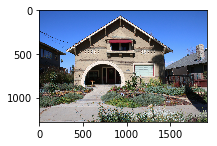

In [158]:
PATH = Path('../images')
HOUSE = 'house.png'
ARCH=vgg16
sz=288
content_img = open_image(PATH/HOUSE)
draw_with_size(content_img, 3)

We'll be using PyTorch APIs in this lesson for the most part, rather than the fastai wrappers around them.
We get a vgg16 precomputed mode, move it onto the GPU, and mark it as non-trainable.

In [159]:
model_full = to_gpu(ARCH(True)).eval()
set_trainable(model, False)

We must create transformation functions that will:
* Resize the image to the request size
* Normalize the inputs
* Change to PyTorch ordering (channels first, rather than channels last)

We apply the transformation to the content image and see that the resulting shape has the number of channels first, and then has the request width and height.

In [160]:
trn_tfms, val_tfms = tfms_from_model(ARCH, sz)
content_tfmd_img = val_tfms(content_img)
content_tfmd_img.shape

(3, 288, 288)

Create a random image (the same size as the content)

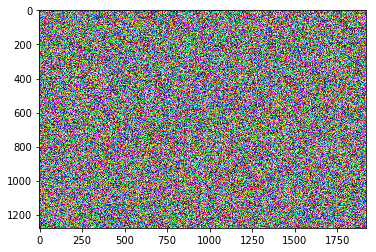

In [161]:
opt_img = random_image(content_img.shape)
plt.imshow(opt_img);

Apply the model transformation to the random image, and then create a PyTorch Variable from it, requesting gradients for the image.

In [163]:
opt_tfmd_img = val_tfms(opt_img)
opt_img_v = V(opt_tfmd_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

Let's look at the model.

In [164]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

We see that there are 43 layers. Let's create a new model (network) based on 
the first 37 layers.

In [165]:
model = nn.Sequential(*children(model_full)[:37])


We'll use VV, which creates a volatile Tensor: one which doesn't need gradients. Our goal is to find the activations at the 37th layer of vgg16 when appliced to the content image.  We'll save those activations and use those to compute the content loss.

Calling ```model``` with our input will return the corresponding output (which is 1x512x18x18, representing:
* 1 input example
* 512 features
* 18 width
* 18 height

In [166]:
targ_t = model(VV(content_tfmd_img[None]))
targ_t.shape

torch.Size([1, 512, 18, 18])

We'll set how many iterations to optimize, as well as the rate at which we print status information.

The optimizer we use is LBFGS. We pass in an iterable of the parameters we want to optimize, along with a learning rate.


In [167]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.6)

Our content loss function is fairly straightforward.  Do a Mean Square Error computation on:
* The output of the model given x as the input
* The saved output of the model (```targ_t```) given the content image as the input 

In [168]:
def content_loss(x): return F.mse_loss(model(x), targ_t)*1000


We define a step function that takes a loss function as input.  We zero out the gradients, call the loss function, then
do backwards propagation. 

In [169]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss


We run the optimizer step function 1000 times. The parameter we pass in is a closure that does one step.
The call to ```partial``` does a partial evaluation of the ```step``` function; that is, it creates a new function which
is equivalent to calling ```step(content_loss)```.

In [170]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,content_loss))


Iteration: 100, loss: 0.6876593828201294
Iteration: 200, loss: 0.3496999740600586
Iteration: 300, loss: 0.25018543004989624
Iteration: 400, loss: 0.20159560441970825
Iteration: 500, loss: 0.1721307337284088
Iteration: 600, loss: 0.15301698446273804
Iteration: 700, loss: 0.13976642489433289
Iteration: 800, loss: 0.12933138012886047
Iteration: 900, loss: 0.1209385022521019
Iteration: 1000, loss: 0.11449237912893295


To view the optimized image, we extract it from the PyTorch variable (with ```.data```), and then call our ```denorm``` function that'll denormalize (the inverse of the normalization transform we do to input images).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


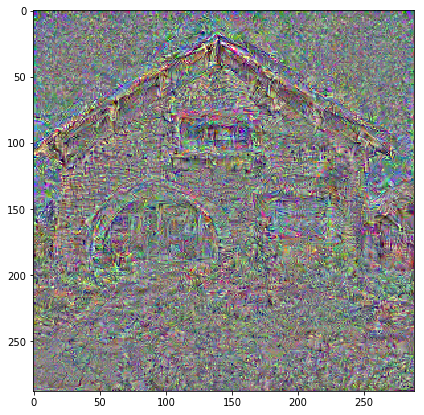

In [171]:
x = denorm(opt_img_v.data, val_tfms.denorm)
draw_with_size(x, 7)

## Saving layers with hooks 

We've seen how we can get the activiations at a particular layer by creating a truncated version of the original model.  An alternative approach is to use a *hook* which will be called every time the module does its forward pass.

We define the ```SaveFeatures``` class which will save the activations in an instance variable called ```features```.

In [180]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

We calculate which layers in the model (Neural Network) are just before the MaxPool layers.  

In [181]:
block_ends = [i-1 for i,o in enumerate(children(model_full))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

We decide we want one of the later layers: 32, at index 3 in ```block_ends```. We use ```SaveFeatures``` to save the features in that layer.

In [182]:
sf = SaveFeatures(children(model)[block_ends[3]])

We define a function that'll return us a newly-initialized image to optimize, along with the optimizer that'll optimize that image.

In [251]:
def get_opt():
    opt_img = random_image(content_img.shape)
    opt_img_v = V(val_tfms(opt_img)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v], lr=0.6)
opt_img_v, optimizer = get_opt()

We run the model on the (transformed) content image and save the activations for the layer of interest into ```targ_v```. Note that it is 512 features, each 36x36.

In [185]:
model(VV(content_tfmd_img[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 36, 36])

Our modified content loss function will now run the model on the input, and then extract the features from the saved layer.  We then do a Mean Squared Error loss calcuation with the just-extracted activations from the saved layer and the already-calculated activations from the same layer for the content(```targ_v```) .

In [186]:
def content_loss2(x):
    model(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*1000

We run our optimizer 1000 times

In [187]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step, content_loss2))

Iteration: 100, loss: 0.3163985013961792
Iteration: 200, loss: 0.15324538946151733
Iteration: 300, loss: 0.1060727909207344
Iteration: 400, loss: 0.08339138329029083
Iteration: 500, loss: 0.07028733193874359
Iteration: 600, loss: 0.0614822655916214
Iteration: 700, loss: 0.05497424677014351
Iteration: 800, loss: 0.05022773891687393
Iteration: 900, loss: 0.046532388776540756
Iteration: 1000, loss: 0.043619707226753235


And, we display the optimized image. Using earlier layers would give us a more literal similarity to the origina
(pixel-by-pixel).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


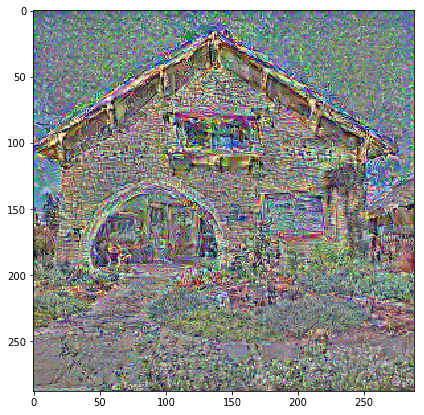

In [188]:
x = denorm(opt_img_v.data, val_tfms.denorm)
draw_with_size(x, 7)

# Converting a random image to resemble the style of another image

The style picture we'l use is a painting by Monet.


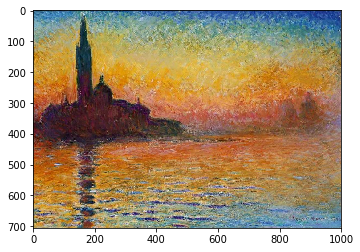

In [196]:
MONET = 'sunset-in-venice.jpg'
style_img = open_image(PATH/MONET)
plt.imshow(style_img);

We scale the style image so that it is the same size as the content.
We keep the same aspect ratio, but as you can see, we lose some of the bottom of the style image.

((1278, 1920, 3), (1278, 1920, 3))

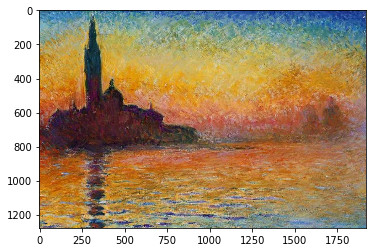

In [198]:
style = scale_match(content_img, style_img)
plt.imshow(style)
style.shape, content_img.shape

We obtain a new random image to optimize, along with its optimizer.

In [204]:
opt_img_v, optimizer = get_opt()

Rather than installing SaveFeatures on one layer of the model, as we did for the content matching, we install it
on all the models that end blocks.  That way, we'll have activations at layers throughout the network, ensuring 
that we can measure differences in both fine-grained style features, as well as larger features.

In [205]:
sfs = [SaveFeatures(children(model_full)[idx]) for idx in block_ends]

We run the content image through our model and save all our activations in ```targ_contents```. Note that this'll give us
the opportunity to decide in our loss function which layer we're actually interested in for our loss function.

In [206]:
model_full(VV(content_tfmd_img[None]))
targ_contents = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_contents]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

We run the style image through our model and save all our activations in ```targ_styles```. 

In [215]:
style_tfmd_img = val_tfms(style_img)
model_full(VV(style_tfmd_img[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

We define the calculation of the gram matrix for a given input.  Note that we effectively calculate the dot-product of each of the flattened vectores.  Also note that we scale by 10^6. 

In [216]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

To calculate the style loss for an image, we run the image through our model, extract the activations at each saved layer,
and then calculate the gram_mse_losses for each of the layers. At the end, we return the total of all those losses.

In [217]:
def style_loss(x):
    model_full(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

We run the optimizer for 1000 steps.

In [218]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: 100, loss: 182.39476013183594
Iteration: 200, loss: 24.606937408447266
Iteration: 300, loss: 9.299477577209473
Iteration: 400, loss: 5.059671401977539
Iteration: 500, loss: 3.3660988807678223
Iteration: 600, loss: 2.5382771492004395
Iteration: 700, loss: 2.0615522861480713
Iteration: 800, loss: 1.7584878206253052
Iteration: 900, loss: 1.5239546298980713
Iteration: 1000, loss: 1.365241527557373


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


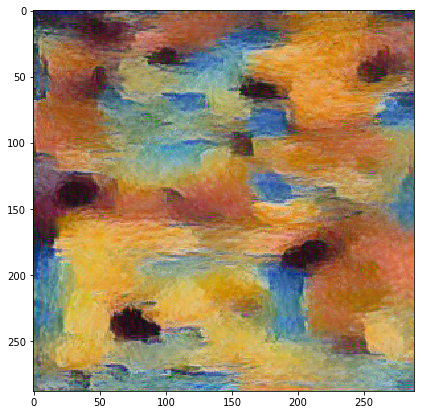

In [219]:
x = denorm(opt_img_v.data, val_tfms.denorm)
draw_with_size(x, 7)

## Style Transfer

Now, we're ready to create an image that is close to the content of the content image, while also close to the style of the style image.

First, we get a fresh image and optimizer.

In [252]:
opt_img_v, optimizer = get_opt()

We save features for the layers of interest in the model.

In [253]:
sfs = [SaveFeatures(children(model_full)[idx]) for idx in block_ends]

We define a combined loss function.  Note that when calculating the content loss, we just use the activations at a specific index.
Also, note that we scale the content loss by a scaling factor.

In [254]:
def comb_loss(x):
    model_full(opt_img_v)
    outs = [V(o.features) for o in sfs]
    cnt_loss   = F.mse_loss(outs[2], targ_contents[2])*50000
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    style_loss = sum(losses)
    return cnt_loss + style_loss

We run the optimizer.

In [255]:
n_iter=0
max_iter=1000
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 100, loss: 842.243896484375
Iteration: 200, loss: 489.305908203125
Iteration: 300, loss: 390.055908203125
Iteration: 400, loss: 344.5957946777344
Iteration: 500, loss: 315.55072021484375
Iteration: 600, loss: 295.6544494628906
Iteration: 700, loss: 280.93450927734375
Iteration: 800, loss: 269.52142333984375
Iteration: 900, loss: 261.275146484375
Iteration: 1000, loss: 255.1650390625


And draw the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


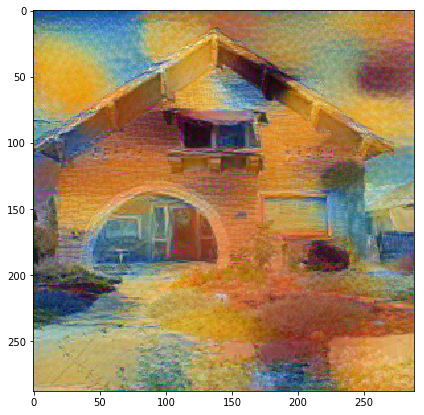

In [256]:
x = denorm(opt_img_v.data, val_tfms.denorm)
draw_with_size(x, 7)